# 5. Forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/23*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.1.2


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

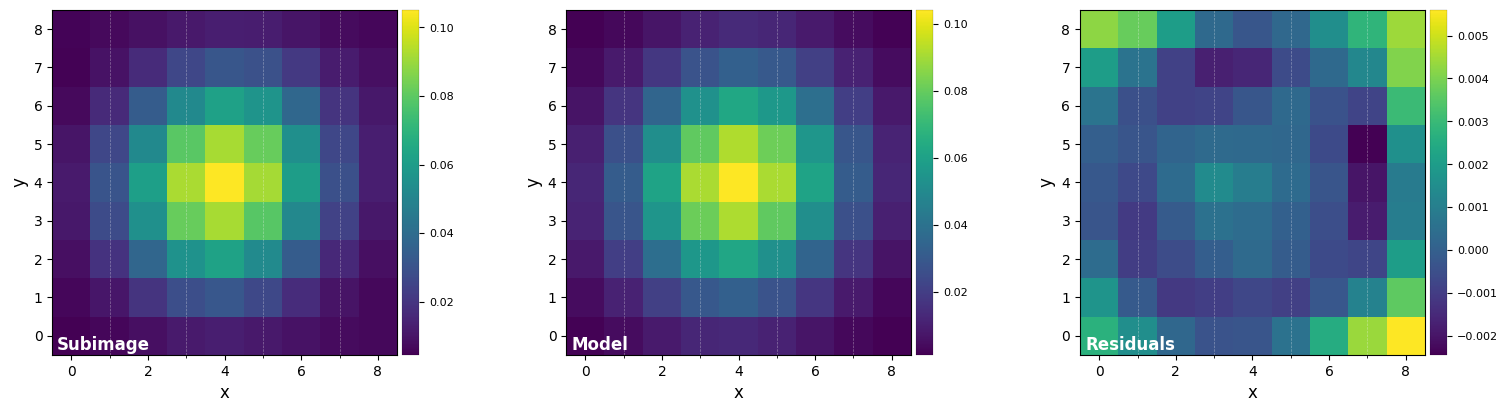

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


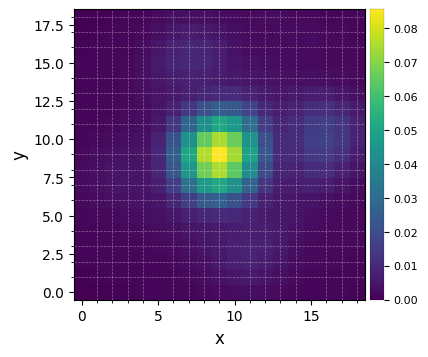

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


[Go to the top](#Table-of-contents)

## 5.2. Generating and injecting synthetic planets

We first select `imlib` and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7`. `opencv` should now be installed by default with VIP, but this was not the case in past versions. If you don't have it and don't want to install it (`pip install opencv-python`), use `skimage`:

In [10]:
# try:
#     import cv2
#     imlib_rot = 'opencv'
#     interpolation = 'lanczos4'
# except:
imlib_rot = 'skimage' #'vip-fft'
interpolation='biquintic' #None   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection are provided in the *derotated* image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs from center)


Let's set the corresponding cartesian coordinates:

In [12]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-29 15:12:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.037595
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.202
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.797
Central pixel S/N = 17.936
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.202
Max S/N (shifting the aperture center) = 18.125
stddev S/N (shifting the aperture center) = 4.003



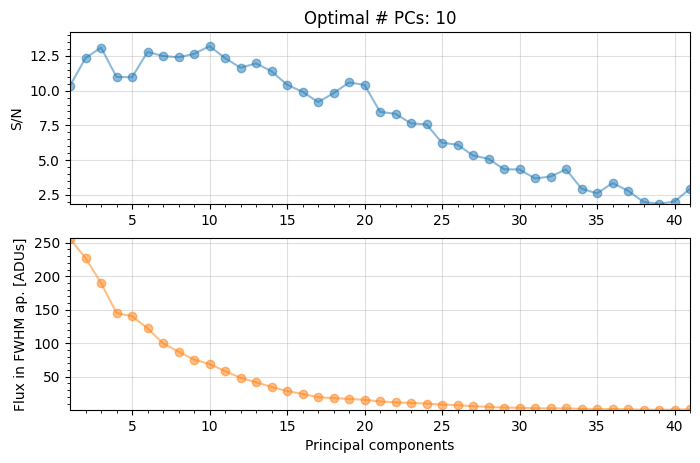

In [13]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [14]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

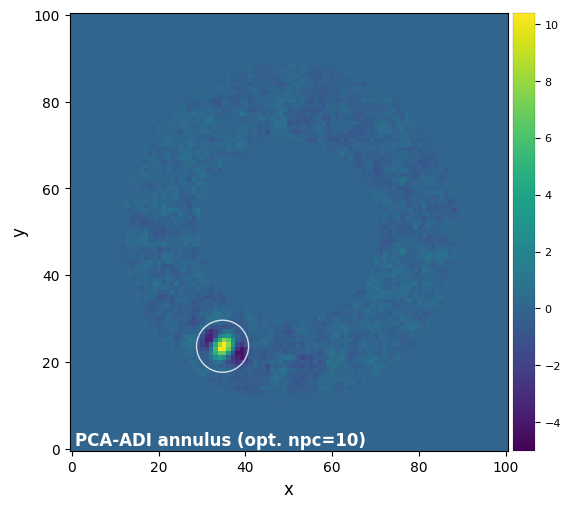

In [15]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

[Go to the top](#Table-of-contents)

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

[Go to the top](#Table-of-contents)

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

In [ ]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  simplex=True, imlib=imlib_rot, interpolation=interpolation,
                                  plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-29 15:12:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   546.678
2/30   0.149   546.615
3/30   0.221   546.522
4/30   0.329   546.383
5/30   0.489   546.177
6/30   0.728   545.868
7/30   1.083   545.421
8/30   1.610   544.755
9/30   2.395   543.751
10/30   3.562   542.240
11/30   5.298   540.017


In [ ]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                                  plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:
- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

In [ ]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, plsc=pxscale_naco,
                               planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                               f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                               imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                               plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

[Go to the top](#Table-of-contents)

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [ ]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [ ]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [ ]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [ ]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

In [ ]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

In [ ]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

In [ ]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

In [ ]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

In [ ]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

[Go to the top](#Table-of-contents)

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [ ]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco,
              'plsc': pxscale_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [ ]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [ ]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [ ]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [ ]:
nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': 2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [ ]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:
- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and will take a long time to run (e.g. ~2h with 2 CPUs of the Apple M1 pro chip). Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

In [ ]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [ ]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [ ]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

In [ ]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

In [ ]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [ ]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

In [ ]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False,
                           verbose=False, save=False, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

In [ ]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, 
                       verbose=True, save=False, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:
- the uncertainties obtained with MCMC when setting `mu_sigma=True`;
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).

[Go to the top](#Table-of-contents)

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [ ]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

In [ ]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, pxscale_naco, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=2, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [ ]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [ ]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [ ]:
sp_unc

For comparison, the uncertainties found by the MCMC procedure were:

In [ ]:
sigma

[Go to the top](#Table-of-contents)

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:
- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [ ]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [ ]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [ ]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [ ]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [ ]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

[Go to the top](#Table-of-contents)